In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(set(''.join(words)))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i+1:s for i,s in enumerate(chars)}
i_to_s[0] = '.'
vocab_size = len(i_to_s)
print(vocab_size)

27


In [8]:
#build the dataset

block_size = 3 #context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = s_to_i[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
#MLP Revisited

n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator = g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [10]:
#same optimization as in the previous notebook

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch for MBSGD
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    Xb, Yb = X_train[ix], Y_train[ix]

    #forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1) #concat the vectors
    h_pre_act = emb_cat @ W1 + b1 #hidden layer pre activation
    h = torch.tanh(h_pre_act) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr*p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #7d indicates that it shoudl be 7 digits long right aligned
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9266
  20000/ 200000: 2.5773
  30000/ 200000: 2.8081
  40000/ 200000: 2.0418
  50000/ 200000: 2.6471
  60000/ 200000: 2.2599
  70000/ 200000: 2.1254
  80000/ 200000: 2.4100
  90000/ 200000: 2.2598
 100000/ 200000: 2.1106
 110000/ 200000: 2.3531
 120000/ 200000: 1.9484
 130000/ 200000: 2.4599
 140000/ 200000: 2.2228
 150000/ 200000: 2.1397
 160000/ 200000: 2.1506
 170000/ 200000: 1.7954
 180000/ 200000: 2.1949
 190000/ 200000: 1.8386


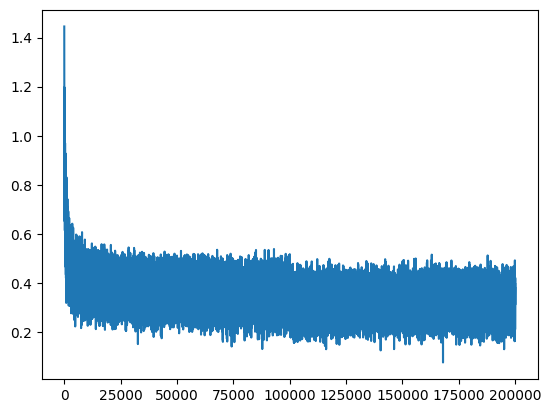

In [11]:
plt.plot(lossi)

In [12]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1262524127960205
val 2.1711676120758057


In [13]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 +b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(i_to_s[i] for i in out))

carlah.
amille.
khirmrix.
taty.
skanden.
jazhubedah.
sara.
kaqui.
ner.
kentzerian.
kaleigh.
ham.
jore.
quint.
salin.
alianni.
waythonielrynix.
kael.
dura.
mer.
